In [69]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sb
import matplotlib.pyplot as plt

In [70]:
# Load data
df = pd.read_csv('creditcard.csv')

# Check for missing values
if df.isnull().values.any():
    df = df.dropna()  # Drop rows with any missing values if any

# Drop irrelevant feature
df.drop('Time', axis=1, inplace=True)

# Scale the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [71]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Filter the data to have only normal transactions for training
normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]


In [72]:
# Split the normal data into training and test sets
X_train, X_test_normal, _, y_test_normal = train_test_split(
    normal_data.drop('Class', axis=1), normal_data['Class'], test_size=0.2, random_state=42)

# Include all fraud transactions and a portion of normal transactions in the test set
X_test = pd.concat([X_test_normal, fraud_data.drop('Class', axis=1)])
y_test = pd.concat([y_test_normal, fraud_data['Class']])

In [73]:
# Normalize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define datasets
train_data = TensorDataset(X_train_tensor, X_train_tensor)
test_data = TensorDataset(X_test_tensor, X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [74]:
# Define the AutoEncoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 14),
            nn.LeakyReLU(),
            nn.Linear(14, 7),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.LeakyReLU(),
            nn.Linear(14, X.shape[1]),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Initialize the model, loss function, and optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Training the model
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [76]:
# Train the AutoEncoder
epoch_losses = []
epochs = 50
for epoch in range(epochs):
    loss = train_model(model, train_loader)
    epoch_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

Epoch 1, Loss: 0.8693226697148737
Epoch 2, Loss: 0.8144531250503134
Epoch 3, Loss: 0.8045556618547467
Epoch 4, Loss: 0.8006714725207599
Epoch 5, Loss: 0.7976289465688022
Epoch 6, Loss: 0.7940507579928177
Epoch 7, Loss: 0.7913339642423153
Epoch 8, Loss: 0.7896120379320946
Epoch 9, Loss: 0.7875701712845884
Epoch 10, Loss: 0.7841283791081651
Epoch 11, Loss: 0.7832086058391167
Epoch 12, Loss: 0.782613878525672
Epoch 13, Loss: 0.7820456625708181
Epoch 14, Loss: 0.7817372705663733
Epoch 15, Loss: 0.781398559067782
Epoch 16, Loss: 0.7810943124414362
Epoch 17, Loss: 0.7808963876798305
Epoch 18, Loss: 0.7805435453396402
Epoch 19, Loss: 0.7801232408055041
Epoch 20, Loss: 0.7796345520921819
Epoch 21, Loss: 0.7790651127872135
Epoch 22, Loss: 0.778519381921514
Epoch 23, Loss: 0.7771419375531111
Epoch 24, Loss: 0.7765070386713115
Epoch 25, Loss: 0.7758241852658413
Epoch 26, Loss: 0.7750625063025287
Epoch 27, Loss: 0.7744778904416082
Epoch 28, Loss: 0.7741751610335501
Epoch 29, Loss: 0.77318969663268

In [89]:
# Modify the evaluation function to return actual loss values per instance
def evaluate_model(model, dataloader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, _ in dataloader:
            output = model(data)
            loss = criterion(output, data)
            losses.extend(loss.item() for _ in range(data.size(0)))
    return losses

In [88]:
# Evaluate model to get losses for each instance in the train set
train_loss = evaluate_model(model, train_loader, criterion)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader, criterion)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.quantile(test_losses, 0.95)
print(f'Anomaly Detection Threshold: {threshold}')

TypeError: iteration over a 0-d array

Accuracy: 0.9586958416877343, 
Precision: 0.17173837005946135, 
Recall: 0.9979674796747967, 
F1 Score: 0.29304685168606387


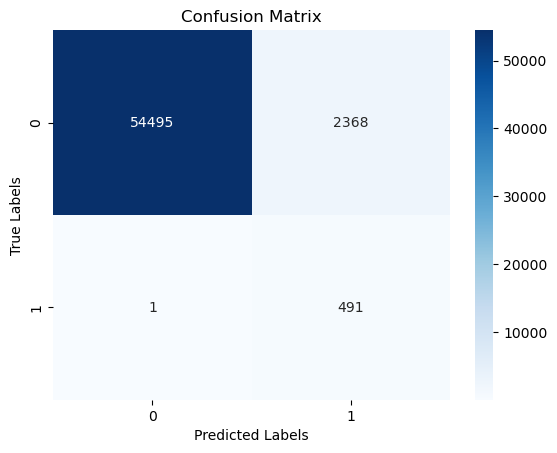

In [79]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [82]:
# # Save the model's state dictionary
# torch.save(model.state_dict(), 'autoencoder_model_weights2.pth')


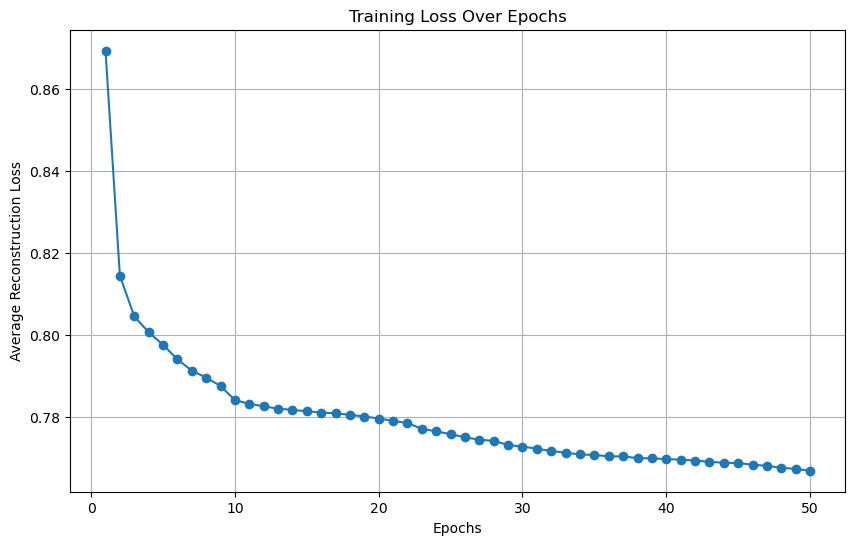

In [86]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Reconstruction Loss')
plt.grid(True)
plt.show()

# After training, evaluate the model to get reconstruction losses and labels
reconstruction_losses, labels = evaluate_model(model, test_loader, criterion)